In [1]:
import gc
import os
import warnings
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from keras import backend as K
warnings.filterwarnings(action='ignore')

K.image_data_format()

Using TensorFlow backend.


'channels_last'

In [2]:
# 혹 다른 데이터 셋 추가(Pretrained Model Weights)로 인해 PATH가 변경된다면 아래 PATH를 수정
DATA_PATH = 'data'
os.listdir(DATA_PATH)

['class.csv',
 'cropped_test',
 'cropped_train',
 'sample_submission.csv',
 'test',
 'test.csv',
 'train',
 'train.csv']

In [3]:
# 이미지 폴더 경로
TRAIN_IMG_PATH = os.path.join(DATA_PATH, 'cropped_train')
TEST_IMG_PATH = os.path.join(DATA_PATH, 'cropped_test')

# CSV 파일 경로
df_train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
df_test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
df_class = pd.read_csv(os.path.join(DATA_PATH, 'class.csv'))

In [4]:
from sklearn.model_selection import train_test_split

df_train["class"] = df_train["class"].astype('str')

df_train = df_train[['img_file', 'class']]
df_test = df_test[['img_file']]

its = np.arange(df_train.shape[0])
train_idx, val_idx = train_test_split(its, train_size=0.8, random_state=42)

X_train = df_train.iloc[train_idx, :]
X_val = df_train.iloc[val_idx, :]

print(train_idx)
print(val_idx)
print()
print(X_train.shape)
print(X_val.shape)
print(df_test.shape)

[4766 4851  533 ... 5390  860 7270]
[1617 9936 2168 ... 1642 9177 4210]

(8012, 2)
(2004, 2)
(6169, 1)


In [5]:
# import cv2

# def color_change(image):
# #     print(type(image))
# #     image = cv2.imread(image, cv2.IMREAD_COLOR)
#     b, g, r = cv2.split(image)
#     rgb_set = ([r, g, b], [r, b, g], [g, r, b], [g, b, r], [b, r, g], [b, g, r])
#     converted_img = cv2.merge(rgb_set[np.random.randint(6)])
#     return converted_img

In [6]:
params = {
    # Generator Parameter
    'rotation_range': 18,
#     'rescale': 1./255,
    'width_shift_range': 0.18,
    'height_shift_range': 0.18,
    'shear_range': 0.18,
    'zoom_range': 0.18,
    'horizontal_flip': True,
    'brightness_range': (0.7, 1.5),
    # Model Parameter
    'img_size': (224, 224),
    'input_shape': (224, 224, 3),
    'nb_train_samples': len(X_train),
    'nb_validation_samples': len(X_val),
    'nb_test_samples': len(df_test),
    'train_epochs': 50,
    'val_epochs': 10,
    'batch_size': 40
}

In [7]:
# from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator

# Define Generator config
train_datagen = ImageDataGenerator(
    rotation_range=params['rotation_range'],
#     rescale=params['rescale'],
    width_shift_range=params['width_shift_range'],
    height_shift_range=params['height_shift_range'],
    shear_range=params['shear_range'],
    zoom_range=params['zoom_range'],
    horizontal_flip=params['horizontal_flip'],
    brightness_range=params['brightness_range'],
    preprocessing_function=preprocess_input)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Make Generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train, 
    directory=TRAIN_IMG_PATH,
    x_col='img_file',
    y_col='class',
    target_size=params['img_size'],
    color_mode='rgb',
    class_mode='categorical',
    batch_size=params['batch_size'],
    seed=42
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=X_val, 
    directory=TRAIN_IMG_PATH,
    x_col='img_file',
    y_col='class',
    target_size=params['img_size'],
    color_mode='rgb',
    class_mode='categorical',
    batch_size=params['batch_size'],
    shuffle=False
)

Found 8012 images belonging to 196 classes.
Found 2004 images belonging to 196 classes.


In [9]:
def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0 :
        return (num_samples // batch_size) + 1
    else:
        return num_samples // batch_size

In [8]:
cnn_model = ResNet50(include_top=False, input_shape=params['input_shape'])
# cnn_model.summary()

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, GlobalAveragePooling2D

# for layer in cnn_model.layers:
#     layer.trainable = False
#     print(layer,layer.trainable)

model = Sequential()
model.add(cnn_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(196, activation='softmax', kernel_initializer='he_normal'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 196)               401604    
Total params: 23,989,316
Trainable params: 23,936,196
Non-trainable params: 53,120
_________________________________________________________________


In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [12]:
%%time
from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath = 'resnet50_18_rot_ep{epoch:02d}_vloss-{val_loss:.4f}_vacc-{val_acc:.4f}.h5'

ckpt = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True)
# es = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')

# callback_list = [ckpt, es]
callback_list = [ckpt]

print(params)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=get_steps(params['nb_train_samples'], params['batch_size']),
    epochs=params['train_epochs'],
    validation_data=validation_generator,
    validation_steps=get_steps(params['nb_validation_samples'], params['batch_size']),
    callbacks=callback_list
)
gc.collect()

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
201/201 [==============================] - 216s 1s/step - loss: 5.3075 - acc: 0.0142 - val_loss: 5.3485 - val_acc: 0.0100

Epoch 00001: val_acc improved from -inf to 0.00998, saving model to resnet50_18_rot_ep01_vloss-5.3485_vacc-0.0100.h5
Epoch 2/30
201/201 [==============================] - 169s 840ms/step - loss: 4.9853 - acc: 0.0287 - val_loss: 14.0148 - val_acc: 0.0065

Epoch 00002: val_acc did not improve from 0.00998
Epoch 3/30
201/201 [==============================] - 168s 837ms/step - loss: 4.5315 - acc: 0.0563 - val_loss: 8.2259 - val_acc: 0.0284

Epoch 00003: val_acc improved from 0.00998 to 0.02844, saving model to resnet50_18_rot_ep03_vloss-8.2259_vacc-0.0284.h5
Epoch 4/30
201/201 [==============================] - 172s 855ms/step - loss: 4.0592 - acc: 0.0992 - val_loss: 5.4829 - val_acc: 0.0639

Epoch 00004: val_acc improved from 0.02844 to 0.06387, saving model to resnet50_18_rot_ep04_vloss-5.4829_vacc-0.0639.h5

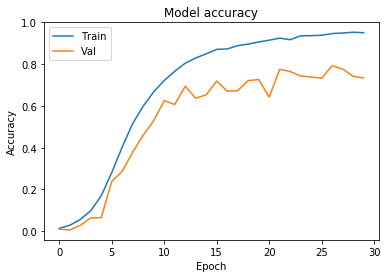

In [17]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

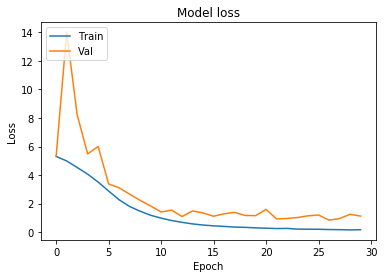

In [18]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [10]:
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input

model = load_model('resnet50_18_rot_ep27_vloss-0.8344_vacc-0.7924.h5')

# Define Generator config
val_datagen2 = ImageDataGenerator(
    rotation_range=params['rotation_range'],
#     rescale=params['rescale'],
    width_shift_range=params['width_shift_range'],
    height_shift_range=params['height_shift_range'],
    shear_range=params['shear_range'],
    zoom_range=params['zoom_range'],
    horizontal_flip=params['horizontal_flip'],
    brightness_range=params['brightness_range'],
    preprocessing_function=preprocess_input)

validation_generator2 = val_datagen2.flow_from_dataframe(
    dataframe=X_val, 
    directory=TRAIN_IMG_PATH,
    x_col='img_file',
    y_col='class',
    target_size=params['img_size'],
    color_mode='rgb',
    class_mode='categorical',
    batch_size=params['batch_size'],
    seed=42
)

filepath = "resnet50_18_rot_in_val_ep{epoch:02d}_loss-{loss:.4f}_acc-{acc:.4f}.h5"
ckpt = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True)
# es = EarlyStopping(monitor='acc', min_delta=0, patience=3, verbose=1, mode='auto')

# callback_list = [ckpt, es]
callback_list = [ckpt]

history = model.fit_generator(
    validation_generator2,
    steps_per_epoch=get_steps(params['nb_validation_samples'], params['batch_size']),
    epochs=params['val_epochs'],
    callbacks=callback_list
)
gc.collect()

Found 2004 images belonging to 196 classes.
Epoch 1/10
51/51 [==============================] - 44s 872ms/step - loss: 0.9990 - acc: 0.7416

Epoch 00001: acc improved from -inf to 0.73703, saving model to resnet50_18_rot_in_val_ep01_loss-1.0087_acc-0.7370.h5
Epoch 2/10
51/51 [==============================] - 39s 761ms/step - loss: 0.6067 - acc: 0.8207

Epoch 00002: acc improved from 0.73703 to 0.82635, saving model to resnet50_18_rot_in_val_ep02_loss-0.5784_acc-0.8263.h5
Epoch 3/10
51/51 [==============================] - 42s 829ms/step - loss: 0.4783 - acc: 0.8589

Epoch 00003: acc improved from 0.82635 to 0.86078, saving model to resnet50_18_rot_in_val_ep03_loss-0.4741_acc-0.8608.h5
Epoch 4/10
51/51 [==============================] - 41s 810ms/step - loss: 0.3614 - acc: 0.8970

Epoch 00004: acc improved from 0.86078 to 0.89521, saving model to resnet50_18_rot_in_val_ep04_loss-0.3633_acc-0.8952.h5
Epoch 5/10
51/51 [==============================] - 43s 842ms/step - loss: 0.2385 - acc

100

In [13]:
%%time
from keras.models import load_model

nb_test_samples = len(df_test)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=TEST_IMG_PATH,
    x_col='img_file',
    y_col=None,
    target_size=params['img_size'],
    color_mode='rgb',
    class_mode=None,
    batch_size=params['batch_size'],
    shuffle=False)

model = load_model('resnet50_18_rot_in_val_ep06_loss-0.1917_acc-0.9391.h5')

prediction = model.predict_generator(
    generator = test_generator,
    steps = get_steps(params['nb_test_samples'], params['batch_size']),
    verbose=1
)

Found 6169 images.
155/155 [==============================] - 45s 293ms/step
Wall time: 1min 47s


In [14]:
predicted_class_indices=np.argmax(prediction, axis=1)

# Generator class dictionary mapping
labels = (train_generator.class_indices)
labels = dict((v, k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

submission = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))
submission["class"] = predictions
submission.to_csv("submission.csv", index=False)
submission.head()

,img_file,class
0,test_00001.jpg,124
1,test_00002.jpg,98
2,test_00003.jpg,157
3,test_00004.jpg,94
4,test_00005.jpg,18


#### **Reference:**
https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c  
https://keras.io/  
http://www.arxiv.org/abs/1512.03385  
https://pillow.readthedocs.io/en/stable/  
https://www.kaggle.com/guglielmocamporese/macro-f1-score-keras